In [107]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [108]:
df_cars = pd.read_csv("autoscout24_data_prepared.csv")
df_cars = df_cars.loc[(df_cars['Fuel_Type']=='Benzin') | (df_cars['Fuel_Type']=='Diesel')]
df_cars = df_cars[['Mileage_num', 'HP_num', 'Fuel_Type', 'Price_num']]
df_cars = df_cars.dropna(axis='index', how='all')
df_cars = df_cars.drop_duplicates()
print(df_cars.shape)
df_cars

(3819, 4)


,Mileage_num,HP_num,Fuel_Type,Price_num
0,75000,245,Diesel,22500
1,46655,184,Benzin,23749
2,138955,306,Benzin,18500
3,43000,360,Benzin,36000
4,43300,252,Benzin,48500
...,...,...,...,...
3966,78000,400,Benzin,58400
3967,315000,232,Benzin,15900
3968,85000,525,Benzin,42000
3969,188920,193,Benzin,9980


In [109]:
df_cars['Fuel_Type'].value_counts()

Benzin    2647
Diesel    1172
Name: Fuel_Type, dtype: int64

In [110]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False, drop='first')
encoder.fit(df_cars[['Fuel_Type']])
onehot = encoder.transform(df_cars[['Fuel_Type']])
df_fuel = pd.DataFrame(onehot, columns=encoder.get_feature_names_out(['Fuel_Type']))
df_onehot = pd.concat([df_cars[['Mileage_num', 'HP_num', 'Price_num']], df_fuel], axis=1)
df_onehot

,Mileage_num,HP_num,Price_num,Fuel_Type_Diesel
0,75000.0,245.0,22500.0,1.0
1,46655.0,184.0,23749.0,0.0
2,138955.0,306.0,18500.0,0.0
3,43000.0,360.0,36000.0,0.0
4,43300.0,252.0,48500.0,0.0
...,...,...,...,...
3656,NaN,NaN,NaN,1.0
3736,NaN,NaN,NaN,0.0
3757,NaN,NaN,NaN,0.0
3777,NaN,NaN,NaN,0.0


In [111]:
df_onehot = pd.get_dummies(df_cars, columns=['Fuel_Type'], prefix=['fuel'])
df_onehot.head()

,Mileage_num,HP_num,Price_num,fuel_Benzin,fuel_Diesel
0,75000,245,22500,0,1
1,46655,184,23749,1,0
2,138955,306,18500,1,0
3,43000,360,36000,1,0
4,43300,252,48500,1,0


In [112]:
X_train, X_test, y_train, y_test = train_test_split(df_onehot[['Mileage_num', 'HP_num', 'fuel_Benzin']], df_onehot['Price_num'], test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

y_test = np.array(y_test)

(3055, 3)
(764, 3)
(3055,)
(764,)


### Linear Regression Model

In [98]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Price_num   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     1080.
Date:                Tue, 07 Nov 2023   Prob (F-statistic):               0.00
Time:                        15:17:55   Log-Likelihood:                -34229.
No. Observations:                3055   AIC:                         6.847e+04
Df Residuals:                    3051   BIC:                         6.849e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.566e+04   1017.406     15.394      

In [103]:
X_test = sm.add_constant(X_test)
predictions_linear_reg = model.predict(X_test)

predictions_linear_reg = np.array(predictions_linear_reg)

print("Predictions with linear regression:")
print(predictions_linear_reg[:10])
print("")
print("Actual values:")
print(y_test[:10])

mse = np.mean((predictions_linear_reg - y_test) ** 2)
rmse = np.sqrt(mse)
print("")
print("Root Mean Squared Error (RMSE):", rmse)

Predictions on the test dataset:
[23458.42976661 40369.24999071  5223.1205811  34942.15930036
 32840.28497056 25494.97638106 -1488.61465053 32130.35174705
  6936.17894918 24839.12197281]

Actual values:
[14500 35000  5900 16500 24500 19800  2500 12000  4350 21900]

Root Mean Squared Error (RMSE): 21693.558333987206


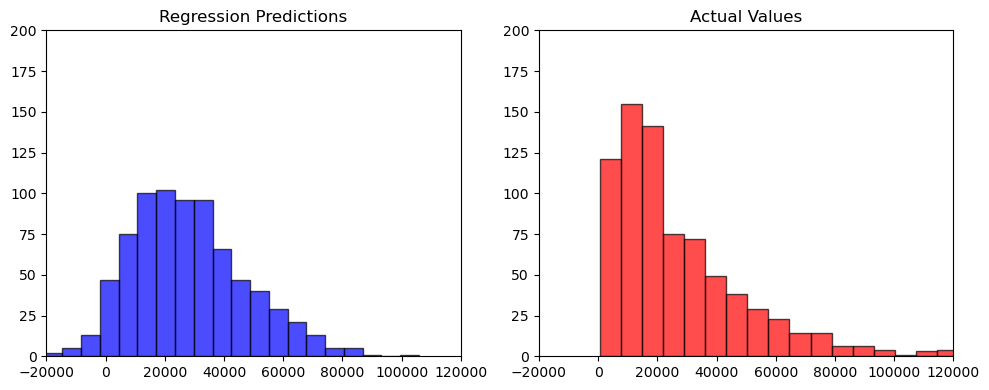

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(predictions_linear_reg, bins=20, color='blue', alpha=0.7, edgecolor='black')
axs[0].set_title('Regression Predictions')
axs[0].set_xlim(-20000, 120000)
axs[0].set_ylim(0, 200)

axs[1].hist(y_test, bins=60, color='red', alpha=0.7, edgecolor='black')
axs[1].set_title('Actual Values')
axs[1].set_xlim(-20000, 120000)
axs[1].set_ylim(0, 200)

plt.tight_layout()
plt.show()

### Random forest regression model

In [105]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)
X_test = sm.add_constant(X_test)
predictions_random_forest = rf_regressor.predict(X_test)

print("Predictions with random forest:")
print(predictions_random_forest[:10])
print("")
print("Actual values:")
print(y_test[:10])

mse = np.mean((predictions_random_forest - y_test) ** 2)
rmse = np.sqrt(mse)
print("")
print("Root Mean Squared Error (RMSE):", rmse)

Predictions on the test dataset:
[14672.78 39437.07  5445.2  25344.   33204.99 20319.5   3729.09 25189.19
  7165.5  12318.  ]

Actual values:
[14500 35000  5900 16500 24500 19800  2500 12000  4350 21900]

Root Mean Squared Error (RMSE): 18476.538119026558


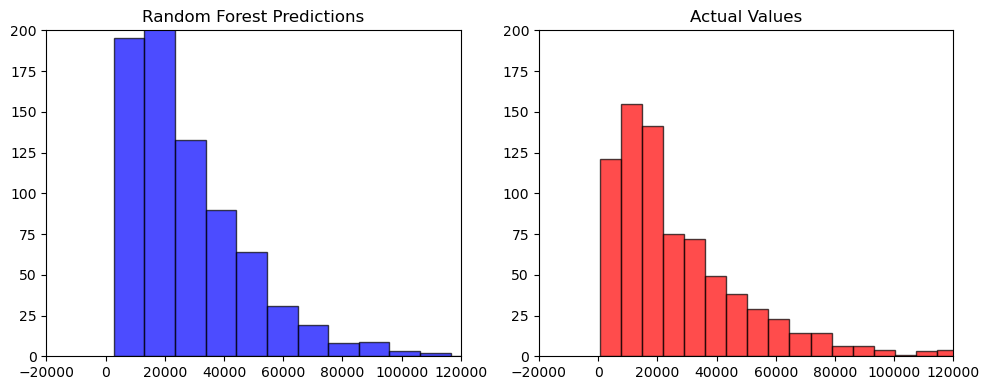

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(predictions_random_forest, bins=20, color='blue', alpha=0.7, edgecolor='black')
axs[0].set_title('Random Forest Predictions')
axs[0].set_xlim(-20000, 120000)
axs[0].set_ylim(0, 200)

axs[1].hist(y_test, bins=60, color='red', alpha=0.7, edgecolor='black')
axs[1].set_title('Actual Values')
axs[1].set_xlim(-20000, 120000)
axs[1].set_ylim(0, 200)

plt.tight_layout()
plt.show()